# Introduction

Road safety is a very important topic around the world, and in the United Kingdom it's no different. Each year thousands of accidents are reported to the police and details such as accident severity, location, date, weather, road conditions, and number of causalities are recorded. There are three datasets to be analyzed: Accident information from 2017, Casualty information from 2017, and Vehicle information from 2017. These files are freely available for download on data.gov.uk. The goal is to make roads safer for everyone by digging into common denominators and using visualization to make sense of the data.

The following notebook uses pyspark and pandas to manipulate the data, using matplotlib and seaborn to visualize the results. While these aren't "big data" files that require processing over a cluster, this serves as an example of how you would leverage big data tools on similar datasets. 

## Import Packages

In [ ]:
#import necessary packages
import pyspark, os, zipfile
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns; sns.set()

## Create sql and spark context to work with pyspark

In [ ]:
#import necessary packages
from pyspark.sql import SQLContext
from pyspark import SparkContext

#create spark context
sc = SparkContext('local', 'accident_analysis')

#create sql context
sqlCtx = SQLContext(sc)

## Download files from data.gov.uk 

(Files are included on my github page if you're out of the country and can't access the website.)

In [ ]:
#use urllib to download files

#get accident data
urllib.request.urlretrieve('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents'
                           '-safety-data/dftRoadSafetyData_Accidents_2017.zip',
                           'C:/Users/ianke/Desktop/accidents.zip')

#get casualty data
urllib.request.urlretrieve('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents'
                           '-safety-data/dftRoadSafetyData_Casualties_2017.zip',
                           'C:/Users/ianke/Desktop/casualties.zip')

#get vehicle data
urllib.request.urlretrieve('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents'
                           '-safety-data/dftRoadSafetyData_Vehicles_2017.zip',
                           'C:/Users/ianke/Desktop/vehicle.zip')

#get data dictionary info
urllib.request.urlretrieve('http://data.dft.gov.uk/road-accidents-safety-data/'
                           'Road-Accident-Safety-Data-Guide.xls',
                           'C:/Users/ianke/Desktop/dictionary.xls')

## Unzip the downloaded files and extract the .csv data files

In [ ]:
#unzip accident data
accidentZip = zipfile.ZipFile('C:/Users/ianke/Desktop/accidents.zip', 'r')
accidentZip.extractall('C:/Users/ianke/Desktop/')
accidentZip.close()

#unzip casualty data
casualtyZip = zipfile.ZipFile('C:/Users/ianke/Desktop/casualties.zip', 'r')
casualtyZip.extractall('C:/Users/ianke/Desktop/')
casualtyZip.close()

#unzip vehicle data
casualtyZip = zipfile.ZipFile('C:/Users/ianke/Desktop/vehicle.zip', 'r')
casualtyZip.extractall('C:/Users/ianke/Desktop/')
casualtyZip.close()

## Delete the unnecessary zip files

In [ ]:
#delete zip folders
os.remove('C:/Users/ianke/Desktop/accidents.zip')
os.remove('C:/Users/ianke/Desktop/casualties.zip')
os.remove('C:/Users/ianke/Desktop/vehicle.zip')

## Fix a header in the "accidents" csv

In a later query having the parenthesis in the column header caused some problems.

In [ ]:
#read in accidents csv
headerfix = pd.read_csv('C:/Users/ianke/Desktop/Acc.csv', low_memory=False)

#change header name
headerfix = headerfix.rename(columns={'Local_Authority_(District)': 'Local_Authority_District'})

#output csv
headerfix.to_csv('C:/Users/ianke/Desktop/Acc.csv', index=False)

## Create spark dataframes to enable spark.sql querying

These dataframes will be directly queried when analyzing and visualizing the data. 

In [ ]:
#create accidents Spark dataframe
accidents = sqlCtx.read.option('header','true').csv('C:/Users/ianke/Desktop/Acc.csv')

#create casualties Spark dataframe
casualties = sqlCtx.read.option('header','true').csv('C:/Users/ianke/Desktop/Cas.csv')

#create vehicles Spark dataframe
vehicles = sqlCtx.read.option('header','true').csv('C:/Users/ianke/Desktop/Veh.csv')

## Create a dictionary object 

Much of the data stored in the three main data files are categorical variables stored as coded values. To define these and convey useful information, a dictionary object can reference each column description tab in the original .xls file. 

In [ ]:
#create dictionary variable
dictionary = pd.ExcelFile('C:/Users/ianke/Desktop/dictionary.xls')

# Data Exploration

The following section outlines different queries and visualizations I used to explore the data. There isn't really a method to my madness, I just created queries I thought might be interesting. 

## Find the top 5 local authorities with the most fatal accidents

This query will help identify which authorities (think of them as counties if you're from the United States) have the most fatal accidents. 

In [ ]:
#create local authority dictionary by specifying the tab in the dictionary variable
localAuthorityPD = pd.read_excel(dictionary, 'Local Authority (District)')

#convert to spark dataframe
localAuthority = sqlCtx.createDataFrame(localAuthorityPD)

#join the accidents and localAuthority spark dataframes and group by local authority
top5 = accidents.join(localAuthority, accidents.Local_Authority_District == localAuthority.code, \
                      "left_outer") \
                .select((localAuthority.label).alias("local_authority_district")) \
                .where(accidents.Accident_Severity == 1) \
                .groupby("local_authority_district").count() \
                .withColumnRenamed("count", "number_of_fatal") \
                .orderBy("number_of_fatal", ascending=False) \
                .limit(5)

#convert final query to pandas dataframe for visualization with matplotlib
top5 = top5.toPandas()

## Visualize most fatal accidents by top 5 local authorities

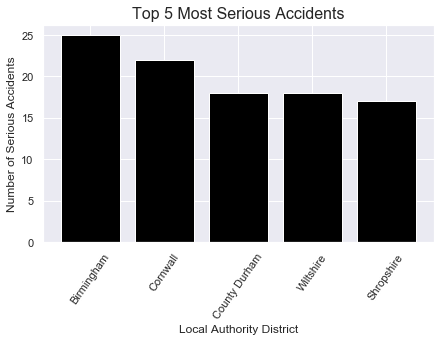

In [54]:
#set figure size
plt.rcParams['figure.figsize'] = [7, 4]

#create bar chart
plt.bar(top5.local_authority_district, height=top5.number_of_fatal, color='black')
plt.xlabel('Local Authority District')
plt.ylabel('Number of Serious Accidents')
plt.title('Top 5 Most Serious Accidents', fontdict = {'fontsize' : 16})
plt.style.use('ggplot')
plt.xticks(rotation=55, fontsize=11)
plt.show()

## Create Vehicle Type Dictionary

To analyze car accidents by vehicle type, a dictionary can be create to define the vehicle code variable.

In [ ]:
#create vehicle type dictionary by specifying the tab
vehicleTypePD = pd.read_excel(dictionary, 'Vehicle Type')

#convert to spark dataframe
vehicleType = sqlCtx.createDataFrame(vehicleTypePD)

## Rank vehicle types that were involved in fatal or serious accidents

In [ ]:
#join the accidents dataframe and the vehicleType dictionary dataframe to vehicles & filter by accident severity
topVehicles = vehicles.join(accidents, "Accident_Index", "inner") \
                      .join(vehicleType, vehicles.Vehicle_Type == vehicleType.code, "left_outer") \
                      .select((vehicleType.label).alias("vehicle_type")) \
                      .where(((accidents.Accident_Severity == 1) | \
                              (accidents.Accident_Severity == 2)) & \
                              (vehicleType.label != "Data missing or out of range")) \
                      .groupby("vehicle_type").count() \
                      .withColumnRenamed("count", "serious_and_fatal_accidents") \
                      .orderBy("Serious_and_Fatal_Accidents", ascending=False)

#output final query
topVehicles = topVehicles.toPandas()

## Visualize which vehicle types are involved in the most accidents

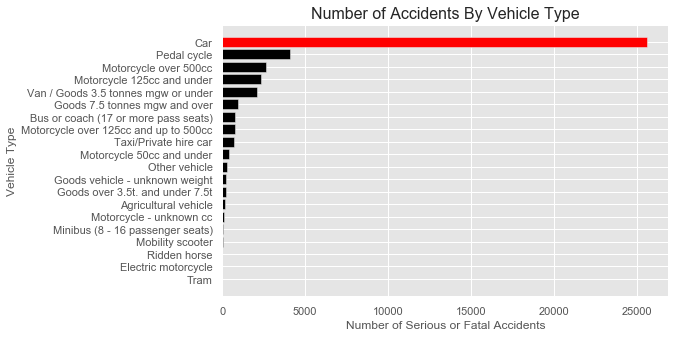

In [56]:
#set figure size
plt.rcParams['figure.figsize'] = [8, 5]

#reverse order so max is on top
topVehicles = topVehicles[::-1]

#add colors to highlight maximum column 
colors = ['black'] * 20
colors[19] = 'red'

#create bar chart (horizontal to fit the long label information)
plt.barh(topVehicles.vehicle_type, width=topVehicles.serious_and_fatal_accidents, color=colors)
plt.xlabel('Number of Serious or Fatal Accidents')
plt.ylabel('Vehicle Type')
plt.title('Number of Accidents By Vehicle Type', fontdict = {'fontsize' : 16})
plt.style.use('ggplot')
plt.show()

## Create age band dictionary

To find the number of casualties in a given age band, a dictionary must be created to define the coded values.

In [ ]:
#create age band dictionary by specifying the tab
ageBandPD = pd.read_excel(dictionary, 'Age Band')

#convert to spark dataframe
ageBand = sqlCtx.createDataFrame(ageBandPD)

## Find the age band of casualties involved in accidents

In [ ]:
#bring in package to convert age code to int for sorting
from pyspark.sql.types import IntegerType

#filter by accident severity, then join in dictionary to display by age band
ageBandFinal = casualties.join(accidents, "Accident_Index", "inner") \
                         .join(ageBand, casualties.Age_Band_of_Casualty == ageBand.code, "left_outer") \
                         .select((casualties.Age_Band_of_Casualty).cast(IntegerType()) \
                                 .alias("age_band_code"), (ageBand.label) \
                                 .alias("age_band_of_casualty")) \
                         .where((accidents.Accident_Severity == 1) & \
                                (ageBand.label != "Data missing or out of range")) \
                         .groupby("age_band_code", "age_band_of_casualty").count() \
                         .withColumnRenamed("count", "fatal_accidents") \
                         .orderBy("age_band_code")

#select only the columns used in visualization
ageBandFinal = ageBandFinal.select("age_band_of_casualty", "fatal_accidents", "age_band_code")

#convert to pandas dataframe
age_band = ageBandFinal.toPandas()

## Visualizing Fatal Accidents by Age Band of Casualty

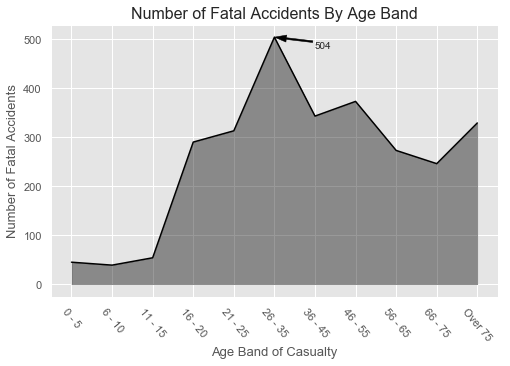

In [57]:
#increase width of chart 
plt.rcParams['figure.figsize'] = [8, 5]

#create line chart
plt.plot(age_band.age_band_of_casualty, age_band.fatal_accidents, color='black')
plt.xlabel('Age Band of Casualty', fontdict = {'fontsize' : 13})
plt.ylabel('Number of Fatal Accidents', fontdict = {'fontsize' : 13})
plt.title('Number of Fatal Accidents By Age Band', fontdict = {'fontsize' : 16})
plt.style.use('ggplot')

#rotate x labels so they are readable
plt.xticks(rotation=310)

#fill plot to simulate bar plot style
plt.fill_between(age_band.age_band_code - 1, age_band.fatal_accidents, color="black", alpha=0.4)

#mark the value of the highest point
plt.annotate('504', xy=(5, 504), xytext=(6, 480), 
             arrowprops={'color':'black', 'width':1.7, 'headwidth':7})
plt.show()

# Find peak hour with the most fatal accidents

Some time-series analysis would be interesting, to see if there is a specific time of day when more accidents occur. I limited the scope to dual carriageway (highways in america) so as to limit it to only high-speed collisions. The time information was stored as "13:46" format, and to view trends each data point would need to be rounded to the nearest half hour. This could be done using the LEFT() function in SQL, but I thought it would be better to showcase the power of RDD's. An RDD allows processing over the cluster, which is where PySpark really becomes useful.

## Use RDD to round "time" column

The snippet below rounds the "time" column, keeping in the "accident index" to join back the data later. 

In [ ]:
#read csv into pandas
pandasTime = accidents.toPandas()

#drop any missing values
pandasTime = pandasTime[["Accident_Index", "Accident_Severity", "Road_Type", "Time"]] \
             .dropna(axis=0, how="any")

#create column with Accident Index and time concatenated to join back after processing
pandasTime["rdd"] = pandasTime["Accident_Index"].map(str) + ":" + pandasTime["Time"].map(str)
pandasTime = pandasTime["rdd"]

#convert to list for RDD
pandasTime = pandasTime.tolist()

#convert to RDD for processing over cluster
RDD = sc.parallelize(pandasTime)

#define function to round to the nearest half hour
def minRound(x):
  if 0 <= int(x[2]) <= 15:
    return [x[0], x[1] + ":" + "00"]
  elif 16 <= int(x[2]) <= 44:
    return [x[0], x[1] + ":" + "30"]
  else:
    if (int(x[1]) + 1) < 10:
      return [x[0], "0" + str((int(x[1])) + 1) + ":" + "00"]
    else:
      return [x[0], str((int(x[1])) + 1) + ":" + "00"]

#split the strings based on the ":" for processing
RDD2 = RDD.map(lambda x: x.split(":"))

#use map to apply function over entire RDD
RDD3 = RDD2.map(minRound)

#use Row function to change RDD into dataframe
from pyspark.sql.types import Row

#function to change RDD into dataframe 
#(found on https://stackoverflow.com/questions/39699107/spark-rdd-to-dataframe-python)
def rdd2DF(x):
    d = {}
    for i in range(len(x)):
        d[str(i)] = x[i]
    return d

#use new function to convert RDD
roundedTime = RDD3.map(lambda x: Row(**rdd2DF(x))).toDF()

#rename columns to make sense
roundedTime = roundedTime.select(roundedTime["0"] \
                         .alias("Accident_Index"), roundedTime["1"] \
                         .alias("Time_Rounded"))

## Join in roundedTime dataframe for time-series analysis

In [ ]:
#join accidents dataframe and the newly created roundedTime dataframe
peakHour = accidents.join(roundedTime, "Accident_Index", "inner") \
                    .select(roundedTime.Time_Rounded) \
                    .where((accidents.Accident_Severity == 1) & (accidents.Road_Type == 3)) \
                    .groupby(roundedTime.Time_Rounded).count() \
                    .withColumnRenamed("count", "fatal_accidents") \
                    .orderBy(roundedTime.Time_Rounded)

#convert to pandas dataframe
peakHour = peakHour.toPandas()

## Visualize Peak Hour Fatal Accidents Occur

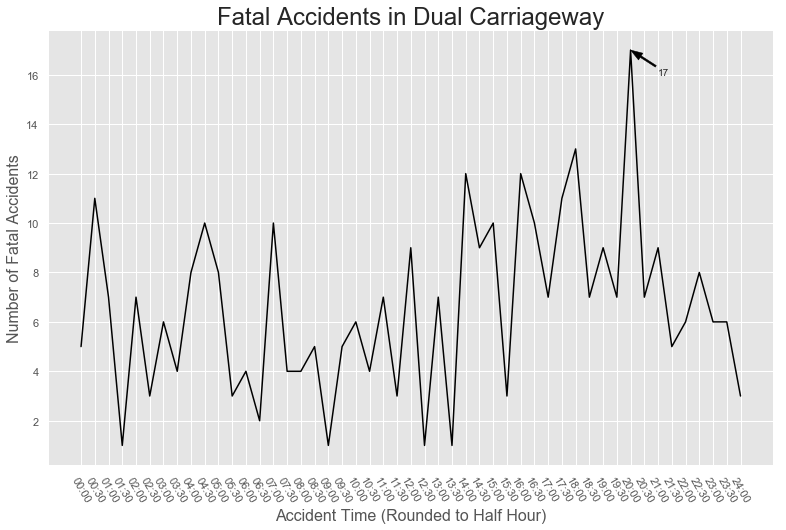

In [58]:
#increase width of chart to account for labels
plt.rcParams['figure.figsize'] = [13, 8]

#create line chart
plt.plot(peakHour.Time_Rounded, peakHour.fatal_accidents, color='black')
plt.xlabel('Accident Time (Rounded to Half Hour)', fontdict = {'fontsize' : 16})
plt.ylabel('Number of Fatal Accidents', fontdict = {'fontsize' : 16})
plt.title('Fatal Accidents in Dual Carriageway', fontdict = {'fontsize' : 24})
plt.style.use('ggplot')

#rotate x labels so they are readable
plt.xticks(rotation=300)

#add arrow annotation
plt.annotate('17', xy=('20:00', 17), xytext=('21:00', 16), 
             arrowprops={'color':'black', 'width':1.8, 'headwidth':8})

plt.show()

# With age comes wisdom?

I thought it would be interesting to create a swarmplot to see if more fatal accidents on wet roads happen to younger people. As you age do you learn to drive more carefully in bad weather? 

## Query to find fatal accidents on wet roads

In [ ]:
#Join the accidents and vehicles dataframes
wetRoad = accidents.join(vehicles, 'Accident_Index', 'inner') \
                   .select(accidents.Road_Surface_Conditions, vehicles.Age_of_Driver) \
                   .where((vehicles.Age_of_Driver != -1) & \
                          (accidents.Road_Surface_Conditions == 2) & \
                          (accidents.Accident_Severity == 1))

#convert to pandas dataframe
wetRoad = wetRoad.toPandas()

#change data type to numeric for graphing
wetRoad['Age_of_Driver'] = wetRoad.Age_of_Driver.astype('int')

## Visualizing fatal accidents on wet roads

Create the plot using seaborn.

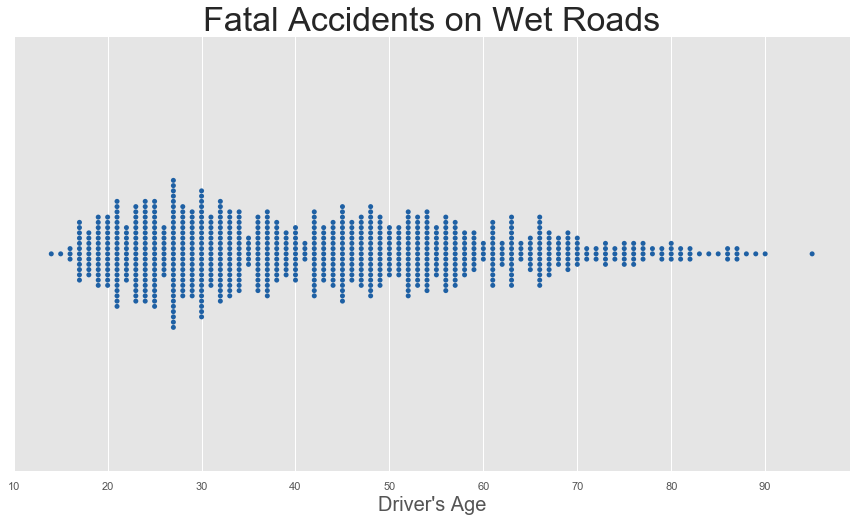

In [67]:
#increase width of chart 
plt.rcParams['figure.figsize'] = [15, 8]

#create swarmplot
sns.swarmplot(x=wetRoad["Age_of_Driver"], color='#1E60A4')
plt.xlabel("Driver's Age", fontdict = {'fontsize' : 20})
plt.title('Fatal Accidents on Wet Roads', fontdict = {'fontsize' : 34})
plt.show()

# Create a heatmap of accidents

Since the latitude and longitude coordinates of each crash are reported, a heatmap can be created using the cartopy package for visualising data on maps. 

## Create dictionary to define "accident severity" code

In [ ]:
#create accident severity dictionary by specifying the tab
severity = pd.read_excel(dictionary, 'Accident Severity')

#convert to spark dataframe
severity = sqlCtx.createDataFrame(severity)

## Query geomap data

In [ ]:
#join the accidents table and severity dictionary 
geoMap = accidents.join(severity, accidents.Accident_Severity == severity.code, "left_outer") \
                  .select(severity.label.alias("accident_severity"), 
                          accidents.Longitude.alias("longitude"), 
                          accidents.Latitude.alias("latitude")) \
                  .where((accidents.Longitude.isNotNull()) & (accidents.Latitude.isNotNull()))

#convert to pandas dataframe
geoMap = geoMap.toPandas()

#change data types to numeric to interact with cartopy
geoMap['latitude'] = geoMap.latitude.astype('float')
geoMap['longitude'] = geoMap.longitude.astype('float')

## Map accident data in UK

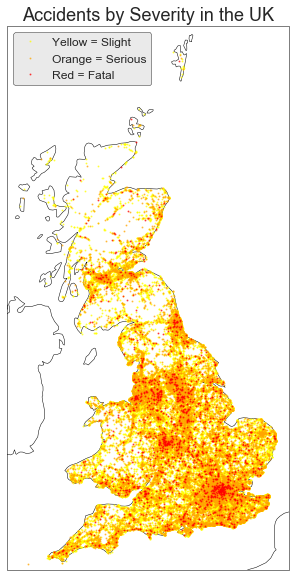

In [68]:
#create dataframe for each severity
fatal = geoMap[geoMap["accident_severity"]=="Fatal"]
serious = geoMap[geoMap["accident_severity"]=="Serious"]
slight = geoMap[geoMap["accident_severity"]=="Slight"]

#map data
plt.figure(figsize=(7, 10))

#get England projection from cartopy package
ax = plt.axes(projection=ccrs.OSGB())
ax.coastlines(resolution='50m')

#plot each severity separately
ax.plot(slight.longitude, slight.latitude, 'o', color='yellow', markersize=1, alpha= .6, 
        label="Yellow = Slight", transform=ccrs.Geodetic())
ax.plot(serious.longitude, serious.latitude, 'o', color='orange', markersize=1, alpha= .6, 
        label="Orange = Serious", transform=ccrs.Geodetic())
ax.plot(fatal.longitude, fatal.latitude, 'o', color='red', markersize=1, alpha= .6, 
        label="Red = Fatal", transform=ccrs.Geodetic())

#add legend and title
plt.legend(fancybox=True, edgecolor="black", prop={'size': 12})
plt.title('Accidents by Severity in the UK', fontdict = {'fontsize' : 18})
plt.show()